## 翻译任务隐藏状态参数可视化分析

#### 数据准备-1：翻译任务准备
在这一阶段，我们的准备工作依照以下顺序进行：
- 借助`chatgpt4`生成10类翻译任务的`prompt`，以json格式存储于`dialogues/role_prompt.json`文件中（该步骤自行手动完成）
- 于`https://tatoeba.org/zh-cn/downloads`下载由`tatoeba`以及全球志愿者提供的中英翻译对照文本数据，保存为`datas/en_ch_trans_data`（该步骤自行手动完成）
- 针对下载的数据进行清洗，只保留英文原文和中文译文，并去除重复项，打乱顺序，将清洗后的原文和译文分别存储于`datas/en_ch_ori_data_processed.txt`与`datas/en_ch_trans_data_processed.txt`文件中

In [1]:
import random
from Taotie.agent_use import ChatAgent
import json
import os

In [2]:
# 制定下载下的文本数据路径
ori_trans_data_path = "datas/en_ch_trans_data"

In [3]:
# 按行读取文件，同时去重
def remove_duplicates_from_file(input_file_path):
    # This set will store the English sentences we have seen
    seen_english_sentences = set()
    unique_lines = []

    # Read the input file
    with open(input_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Each line is expected to have an English sentence followed by its translation, separated by a tab
            if '\t' in line:
                english, _ = line.split('\t', 1)
                # Check if the English sentence has already been seen
                if english not in seen_english_sentences:
                    # If not, add it to the set of seen sentences and keep the line
                    seen_english_sentences.add(english)
                    unique_lines.append(line)
    
    # Write the unique lines to the output file
    return unique_lines

en_ch_trans_data_noreoeated = remove_duplicates_from_file(ori_trans_data_path)

In [7]:
# 单独取出原文与译文
processed_lines = []

for i in range(len(en_ch_trans_data_noreoeated)):
    line = en_ch_trans_data_noreoeated[i]
    parts = line.strip().split('\t')
    if len(parts) == 4:
        original_text = parts[1]  # The original text
        trans_text = parts[3]  # The original text
        processed_lines.append([original_text,trans_text])

In [ ]:
# 打乱后分别保存
random.seed(42)
random.shuffle(processed_lines)
with open('datas/en_ch_ori_data_processed.txt', 'w', encoding='utf-8') as outfile:
    for processed_line in processed_lines:
        outfile.write(processed_line[0] + '\n')

with open('datas/en_ch_trans_data_processed.txt', 'w', encoding='utf-8') as outfile:
    for processed_line in processed_lines:
        outfile.write(processed_line[1] + '\n')

#### 数据准备-2：翻译任务模拟与隐藏层状态搜集

在这一阶段，我们借助`chatglm3-6b`的 4bit 量化模型，进行翻译任务模拟，并将每次任务中模型transformer部分的每一次生成的所有隐藏层状态保存下来

为什么选择`chatglm3-6b`的4bit量化模型——因为其足够`笨`，较容易模拟出未成功完成任务的情况

注意——在运行数据获取代码前，请按照`readme.md`文件中的指引替换chatglm3-6b的本地模型文件，以确保隐藏层状态信息能够正常保存

确保`visual_config.json`中的路径正确（`ori_hidden_state_path`路径默认为`THUDM`下的`hid`目录）

In [4]:
from config_parse import VisualConfig
from Taotie.agent_use import ChatAgent
from visual_logger import logger
import json
from random import randint
import os
visualconfig = VisualConfig("./visual_config.json")

In [4]:
# TaskDataGenerator可以向本地chatglm3-6b批量发送任务请求，并将任务推理过程中的相关数据（对话内容与隐藏层状态参数）保存整理
class TaskDataGenerator():
    def __init__(self, visualconfig, task_pattern, local_model = "chatglm3-6b"):
        self.task_pattern = task_pattern
        self.model_name = local_model
        self.config = visualconfig
        self.task_prompts = None
        self.text_prompts = None
        self.ori_hidden_state_path = self.config.ori_hidden_state_path
        self.target_hidden_state_path = os.path.join(os.path.abspath(self.config.save_dir_path), self.task_pattern)
        self.processing_text_index = 0
        self.agent = ChatAgent(self.model_name)
        logger.info('using local model: {self.model_name}')
        self.init_prompts()
        if not os.path.exists(self.target_hidden_state_path):
            os.mkdir(self.target_hidden_state_path)

    def start_fetch(self, start_index, end_index):
        for i in range(start_index, end_index):
            self.processing_text_index = i
            self.fetch_one_date()

    def fetch_one_date(self):
        self.check_ori_hidden_state_path_empty()
        # 先随机取一个任务描述作为当前agent的行为准则
        tmp_task_prompt = self.get_random_task_prompt()
        # self.agent.init_messages_by_sentence(tmp_task_prompt)
        # 第一次的初步post
        self.agent.prompt_add(tmp_task_prompt)
        logger.info(f'Current task prompt: \t{tmp_task_prompt}')
        init_result = self.agent.prompt_post()
        logger.info(f'task return: \t{init_result}')
        # 然后是后续的自由发挥

        # 然后是第二次的自由发挥
        for text in self.text_prompts[self.processing_text_index]:
            self.agent.prompt_add(text)
            logger.info(f'Next try: \n{text}')
            second_result = self.agent.prompt_post()
            logger.info(f'gpt return: \n{second_result}')
        # 整理结果，保存记录
        self.task_result_record()
        self.hidden_state_move()
        # 代理初始化
        self.agent.messages = []

    def check_ori_hidden_state_path_empty(self):
        # 检查self.ori_hidden_state_path文件夹中是否为空
        return not os.listdir(self.ori_hidden_state_path)

    def hidden_state_move(self):
        # 将参数文件移入具体的index对应文件夹中
        tmp_full_target_path = os.path.join(self.target_hidden_state_path, f'{str(self.processing_text_index)}')
        if not os.path.exists(tmp_full_target_path):
            os.makedirs(tmp_full_target_path)
        for file in os.listdir(self.ori_hidden_state_path):
            os.rename(os.path.join(self.ori_hidden_state_path, file), os.path.join(tmp_full_target_path, file))


    def get_random_task_prompt(self):
        return self.task_prompts[self.processing_text_index]

    def task_result_record(self):
        tmp_target_path = os.path.join(self.target_hidden_state_path, str(self.processing_text_index))
        if not os.path.exists(tmp_target_path):
            os.makedirs(tmp_target_path)
        with open(os.path.join(tmp_target_path, 'dialogue.txt'), 'w', encoding='utf-8') as f:
            json.dump(self.agent.messages, f,ensure_ascii=False, indent=4)

    def init_prompts(self):
        with open(self.config.role_setting_prompt_json, 'r', encoding='utf-8') as f:
            role_setting_prompts = json.load(f)
        self.task_prompts = role_setting_prompts[self.task_pattern]
        logger.info(f"successfully load {str(len(self.task_prompts))} task_prompts of task: {self.task_pattern}")
        self.text_prompts = []
        with open(self.config.text_prompt_data_path[self.task_pattern], 'r', encoding='utf-8') as f:
            for line in f:
                self.text_prompts.append(line.split('\t'))
        logger.info(f"successfully load {str(len(self.text_prompts))} text_prompts of task: {self.task_pattern}")
    
    # 从预设的同一任务的多种任务描述中选取一种作为当前的prompt
    def get_random_task_prompt(self):
        return self.task_prompts[randint(0, len(self.task_prompts) - 1)]

In [5]:
test_TaskDataGenerator = TaskDataGenerator(visualconfig, task_pattern="datas/translator")
# 根据 en_ch_ori_data_processed.txt 文件前1000行文本执行翻译任务
test_TaskDataGenerator.start_fetch(0, 2)

2023-11-20 22:43:43,818 - my_logger - INFO - api_base:openai	llm version: chatglm3-6b
2023-11-20 22:43:43,819 - visual_logger - INFO - using local model: {self.model_name}
2023-11-20 22:43:43,819 - visual_logger - INFO - successfully load 10 task_prompts of task: translator
2023-11-20 22:43:43,860 - visual_logger - INFO - successfully load 63493 text_prompts of task: translator
2023-11-20 22:43:43,861 - visual_logger - INFO - Current task prompt: 	Your role is that of a language converter. Take the English sentence 'Sustainable practices are becoming increasingly important in manufacturing' and give me the Chinese equivalent.
2023-11-20 22:43:47,903 - visual_logger - INFO - task return: 	
 可持续的实践在制造业中变得越来越重要。
2023-11-20 22:43:47,903 - visual_logger - INFO - Next try: 
I have three tickets.

2023-11-20 22:43:49,358 - visual_logger - INFO - gpt return: 

 我有三个单据。
2023-11-20 22:43:49,467 - visual_logger - INFO - Current task prompt: 	Imagine you're a translation device; your current task 

代码运行结束后，会在`datas/translator`中出现一系列以原文在`en_ch_ori_data_processed.txt`中的行号命名的目录，目录中有两类文件，一类是以时间戳命名的`npz`文件，保存了每一次生成后的29层隐藏层状态，另一为`dialogues.txt`，保存了此次任务的对话信息，后续的数据标签也将保存于该文件中。
<br><br>

#### 数据准备-3：数据标签标记

在这一阶段，我们借助`chatglm_lite` API，为我们的模拟数据集打上标签，成功实现了翻译任务的标记为`0`，未能够成功完成任务的，标记为`1`

In [ ]:
trans_data_dir_path = "translator"
class trans_tag_adder():
    def __init__(self, trans_data_dir_path, model_name):
        self.trans_data_dir_path = trans_data_dir_path
        self.text_count = 0
        self.processing_index = 0
        for root, dirs, _ in os.walk(self.trans_data_dir_path):
            for dir in dirs:
                if os.path.exists(os.path.join(root, dir, "dialogue.txt")):
                    self.text_count += 1
        self.check_trans_agent = ChatAgent(model_name)
        self.check_trans_agent.init_messages_by_json("datas/trans_checker_ch.json")

    def start_check(self, start_index, end_index):
        for index in range(start_index, end_index):
            self.processing_index = index
            print(f"processing index:{self.processing_index}")
            self.add_one_tag(self.processing_index)

    def add_one_tag(self, index):
        dialogue_path = os.path.join(self.trans_data_dir_path, str(index), "dialogue.txt")
        with open(dialogue_path, 'r', encoding='utf-8') as file:
            data_list = json.load(file)
            check_flag = self.check_is_correct_tran(data_list[-2]["content"],data_list[-1]["content"])
            write_dict = {"tag": check_flag, "dialogues": data_list}
        print(f"index-{self.processing_index} judged as {check_flag}")
        with open(dialogue_path, 'w', encoding='utf-8') as file:
            json.dump(write_dict, file, ensure_ascii=False, indent=4)

    def check_is_correct_tran(self, user_content:str, assistant_content:str):
        if self.is_more_than_half_english(assistant_content):
            check_flag = "1"
            print("translation too much English.")
            return check_flag
        user_content = user_content.replace('\n', '').replace('\\', '')
        assistant_content = assistant_content.replace('\n', '').replace('\\', '')
        prompt_text = f"['Original text': '{user_content}', 'Translated text': '{assistant_content}']"
        print(f"prompt_text:{prompt_text}")
        self.check_trans_agent.prompt_add(prompt_text)
        result = self.check_trans_agent.prompt_post(remember_flag=False,T = 0.05)
        print(f"result:{result}")
        if result[0]=="\"" and result[-1]=="\"":
            result = result[1:-1]
        if result.endswith("0") or result.endswith("1"):
            return result[-1]
        else:
            print(f"index-{self.processing_index}-check failed")
            return f"check_failed"
        
    def is_more_than_half_english(self, s):
        english_char_count = sum(1 for char in s if char.isalpha() and char.isascii())
        total_char_count = len(s)
        # Check if English characters are more than 50%
        return english_char_count > total_char_count / 2

In [ ]:
trans_checker = trans_tag_adder("datas/translator","chatglm_lite")
trans_checker.start_check(0, 1034)

数据以及对应标签准备好后，就可以进行可视化进程了

## 数据可视化处理

#### 针对当前数据文件结构，设计一个用于取用数据的类

In [3]:
import os
import json
import numpy as np
translator_hid_state_data_path = "./datas/translator-chatglm2-6b"
class HidDataFetch():
    def __init__(self, hid_datas_path) -> None:
        self.hid_datas_path = hid_datas_path
        self.dialogues_num = self.count_dirs(self.hid_datas_path)
        print("dialogues_num:", self.dialogues_num)
        self.dialogues = []
        self.tag_list = []
        self.datas = []
        self.fetch_all_dialogues()
        self.init_tags()
        # self.fetch_all_datas()

    # 将所有dialogue.txt读取整合
    def fetch_all_dialogues(self):
        for i in range(self.dialogues_num):
            self.dialogues.append(self.load_dialogue_by_index(i))
    # 将所有隐藏状态参数读取整合
    def fetch_all_datas(self):
        for i in range(self.dialogues_num):
            self.datas.append(self.load_data_by_index(i))

    # 读取对应index的dialogue.txt
    def load_dialogue_by_index(self, index):
        with open(self.hid_datas_path + "/" + str(index) + "/dialogue.txt", "r", encoding="utf-8") as f:
            dialogue = json.load(f)

    # 提取出所有的tag
    def init_tags(self):
        for diagolue in self.dialogues:
            self.tag_list.append(diagolue['tag'])

    # 统计文件夹中下有多少文件和文件夹
    def count_dirs(self, path):
        return len(os.listdir(path))
    
    # 从硬盘中读取对应的dialogue.txt
    def load_dialogue_by_index(self, index):
        if index >= self.dialogues_num:
            print("index out of range")
            return None
        hid_data_path = os.path.join(self.hid_datas_path, str(index), 'dialogue.txt')
        # print(hid_data_path)
        hid_data = {}
        with open(hid_data_path, 'r', encoding='utf-8') as f:
            hid_data = json.load(f)
        return hid_data
    
    # 获取某index对应的完整的dialogue.txt
    def fetch_by_index(self, index):
        return self.dialogues[index]
    
    # 获取某index的tag
    def fetch_tag_by_index(self, index):
        if index >= self.dialogues_num:
            print("index out of range")
            return None
        return self.dialogues[index]['tag']
    
    # 获取某index对应的完整的对话内容
    def fetch_dialogue_by_index(self, index):
        if index >= self.dialogues_num:
            print("index out of range")
            return None
        return self.dialogues[index]['dialogues']

    # 获取符合某个tag的所有index
    def fetch_index_list_by_tag(self, tag):
        return [index for index in range(self.dialogues_num) if self.dialogues[index]['tag'] == tag]

    # 获取某个index下的所有data
    def load_data_by_index(self, index):
        data_dir_path = os.path.join(self.hid_datas_path, str(index))
        datas = []
        for file in sorted(os.listdir(data_dir_path)):
            if file.endswith(".npz"):
                data_path = os.path.join(data_dir_path, file)
                data_f = np.load(data_path)
                datas.append(np.array(list(data_f.values())))
                data_f.close()
        return datas
    
    # 获取某个index下的特定的data
    def load_special_data(self, path_index, round, speaker, file_index):
        filename = self.get_special_filename(path_index, round, speaker, file_index)
        data_dir_path = os.path.join(self.hid_datas_path, str(path_index))
        data_path = os.path.join(data_dir_path, filename)
        data_f = np.load(data_path)
        datas = np.array(list(data_f.values()))
        data_f.close()
        return datas
    
    # 获取特定隐藏层的file_index
    def get_special_filename(self, path_index, round, speaker, file_index):
        data_dir_path = os.path.join(self.hid_datas_path, str(path_index))
        filename_list = []
        user_filename_list = []
        assistant_filename_list = []
        tmp_round = 0
        for file in sorted(os.listdir(data_dir_path)):
            if file.endswith(".npz"):
                filename_list.append(file)
        base_size = os.path.getsize(os.path.join(data_dir_path, filename_list[1]))
        for file in filename_list:
            file_size = os.path.getsize(os.path.join(data_dir_path, file))
            if file_size > base_size:
                user_filename_list.append([file])
                tmp_round = tmp_round + 1
            else:
                if tmp_round > len(assistant_filename_list): 
                    assistant_filename_list.append([file])
                else:
                    assistant_filename_list[tmp_round-1].append(file)
        if speaker == "user":
            return user_filename_list[round][file_index]
        elif speaker == "assistant":
            return assistant_filename_list[round][file_index]
        else:
            return 0
    
    # 获取user输入文本开始对应的index
    def get_use_text_index_by_index(self, index):
        user_index_list = [index for index, element in enumerate(self.load_data_by_index(index)) if element.shape[1] > 1]
        return user_index_list
        
        



#### 加载数据

In [4]:
data_fetcher = HidDataFetch(translator_hid_state_data_path)

dialogues_num: 1034


#### 查看一下几类数据的分布

In [5]:
tag_wrong_trans_index_list = data_fetcher.fetch_index_list_by_tag("1")
tag_correct_trans_index_list = data_fetcher.fetch_index_list_by_tag("0")
ori_question_index_list = [index for index in range(data_fetcher.dialogues_num) if data_fetcher.dialogues[index]['dialogues'][-2]['content'][-2] == "?"]
no_qes_and_wrong_trans_index_list = [index for index in tag_wrong_trans_index_list if index not in ori_question_index_list]
print(f"翻译有问题的情况有{len(tag_wrong_trans_index_list)}个\n翻译正确的情况有{len(tag_correct_trans_index_list)}个")
print(f"原文以问号结尾的问题的情况有{len(ori_question_index_list)}个")
print(f"翻译有错误，但是原文不是问题的情况有{len(no_qes_and_wrong_trans_index_list)}个")

翻译有问题的情况有182个
翻译正确的情况有844个
原文以问号结尾的问题的情况有127个
翻译有错误，但是原文不是问题的情况有100个


In [6]:
#分别选取100个正例和100个反例
h1_no_qes_and_wrong_trans_index_list = no_qes_and_wrong_trans_index_list[:100]
h1_tag_correct_trans_index_list = tag_correct_trans_index_list[:100]

#### 查看一个典型正例和一个典型反例

In [7]:
print(f"first 5 obey:{str(tag_correct_trans_index_list[:5])}")
print(f"first 5 disobey:{str(no_qes_and_wrong_trans_index_list[:5])}")

first 5 obey:[0, 2, 3, 5, 6]
first 5 disobey:[4, 11, 37, 38, 51]


In [8]:
data_fetcher.fetch_dialogue_by_index(6)

[{'role': 'user',
  'content': "You've been designated as a language translator. Please translate the following into Chinese: 'The entrepreneur's keynote speech was truly inspiring and visionary.'"},
 {'role': 'assistant', 'content': '\n 创业者的演讲真正令人鼓舞和具有远见。'},
 {'role': 'user', 'content': 'While I breathe, I hope.\n'},
 {'role': 'assistant', 'content': '\n 在我呼吸的时候，我希望。'}]

In [9]:
data_fetcher.fetch_dialogue_by_index(51)

[{'role': 'user',
  'content': "Your role is that of a language converter. Take the English sentence 'Sustainable practices are becoming increasingly important in manufacturing' and give me the Chinese equivalent."},
 {'role': 'assistant', 'content': '\n 可持续的实践在制造业中变得越来越重要'},
 {'role': 'user', 'content': 'This is a difficult math problem.\n'},
 {'role': 'assistant',
  'content': "\n I\\'m sorry, but I am not able to solve math problems. I am a language model designed to assist with general knowledge and information, as well as provide definitions for words and phrases. If you have a specific math problem that you would like help with, it would be best to seek assistance from a qualified math teacher or tutor."}]

In [10]:
#### assistant最后一次回答开始后的state
data_fetcher.load_data_by_index(6)[data_fetcher.get_use_text_index_by_index(6)[1]+1].shape

(29, 1, 1, 4096)

In [16]:
data_fetcher.get_special_filename(0,-1,'assistant',0)

'hidden_states_20231120_224348218.npz'

In [17]:
#### 我们只使用最后一层transformer的隐藏层输出
data_fetcher.load_special_data(1,-1,'user',0)[:, -1, :, :].shape

(29, 1, 4096)

In [28]:
data_fetcher.load_data_by_index(95)[0].shape

(29, 71, 1, 4096)

#### 获取目标数据

在这里，我们首先尝试获取了所有任务中，用户将最后一次任务完整输入后，最后一层transformer隐藏层的输出。

In [11]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import clear_output

def process_data(i):
    # tmp_data = data_fetcher.load_data_by_index(i)[second_assistant_start_index].reshape(29, 4096)
    # tmp_data = data_fetcher.load_special_data(i,-1,'assistant',0).reshape(29, 4096)
    # 用户最后一次任务输入之后的所有transformer隐藏层输出
    tmp_data = data_fetcher.load_special_data(i,-1,'user',0)[:, -1, :, :].reshape(29, 4096)

    tmp_label = str(data_fetcher.fetch_tag_by_index(i))
    return i, tmp_data, tmp_label  # 返回索引和数据

# 初始化列表
datas = [None] * len(data_fetcher.dialogues)
labels = [None] * len(data_fetcher.dialogues)
count = 0
with ThreadPoolExecutor(max_workers=64) as executor:
    futures = [executor.submit(process_data, i) for i in range(len(data_fetcher.dialogues))]
    # for future in as_completed(futures):
    #     i, tmp_data, tmp_label = future.result()
    #     datas[i] = tmp_data  # 使用索引直接插入到正确的位置
    #     labels[i] = tmp_label
    #     count = count+1
    #     print(count)

    total_dialogues = len(data_fetcher.dialogues)
    for future in as_completed(futures):
        i, tmp_data, tmp_label = future.result()
        datas[i] = tmp_data  # Use the index to insert at the correct position
        labels[i] = tmp_label
        count += 1
        # Calculate the percentage of completion
        percent_complete = (count / total_dialogues) * 100
        # Print the real-time percentage progress
        if count % 10 == 0:
            clear_output(wait=True)
            print(f"Progress: {percent_complete:.2f}% Complete ({count}/{total_dialogues})")




Progress: 99.61% Complete (1030/1034)


In [12]:
# 只取最后一层隐藏层输出
datas_layer29 = np.array([data[28] for data in datas])

In [13]:
# 获取labels，没能够成功识别的，默认为正确完成翻译任务
labels_int = np.array([int(y) if y=='0' or y=='1' else 0  for y in labels])

#### 尝试t-SNE降维到三维

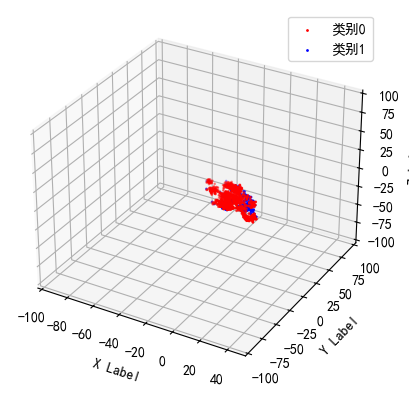

In [14]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif']=['SimHei'] # 设置字体为黑体，解决Matplotlib中文乱码问题

plt.rcParams['axes.unicode_minus']=False # 解决Matplotlib坐标轴负号'-'显示为方块的问题

# 假设您的输入数据是一个名为data的numpy数组，形状是(29, 4096)
# 假设labels是标签数组

# 应用t-SNE降维到三维
tsne = TSNE(n_components=3, random_state=42)
data_tsne = tsne.fit_transform(np.array(datas_layer29))

# 可视化
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 假设您有两个标签类别，用0和1表示
ax.scatter(data_tsne[labels_int == 0, 0], data_tsne[labels_int == 0, 1], data_tsne[labels_int == 0, 2], c='r', s=1,label='类别0')
ax.scatter(data_tsne[labels_int == 1, 0], data_tsne[labels_int == 1, 1], data_tsne[labels_int == 1, 2], c='b', s=1,label='类别1')

plt.xlim(-100, 50)
plt.ylim(-100, 100)
ax.set_zlim(-100, 100)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend()

plt.show()

In [68]:
len(datas_layer29)

1034

In [33]:
# 统计labels_int中0的个数和1的个数
nums_0 = len(labels_int[labels_int==0])
nums_1 = len(labels_int[labels_int==1])

#### 应用t-SNE降维到三维

In [9]:
# 自由视角的三维图
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

# 假设您的输入数据是一个名为data的numpy数组，形状是(29, 4096)
# 假设labels是标签数组

# 应用t-SNE降维到三维
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
data_tsne = tsne.fit_transform(datas_layer29)

# 将降维后的数据和标签转换为DataFrame
df = pd.DataFrame(data_tsne, columns=['x', 'y', 'z'])
df['label'] = labels_int  # 添加标签列

# 创建一个颜色映射字典，这里0对应红色，1对应蓝色
color_map = {0: 'blue', 1: 'red'}

# 将标签数组映射到颜色
colors = [color_map[label] for label in labels_int]

# 使用Plotly创建交互式三维散点图
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color=colors, labels={'label': 'Label'},
                    title='t-SNE 3D Visualization')
fig.update_traces(marker=dict(size=3))
# fig.show()
fig.show(renderer="browser")

#### 应用主成分分析（PCA）降维到三维

In [15]:
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# 假设您的输入数据是一个名为datas_layer29的numpy数组，形状是(29, 4096)
# 假设labels_int是标签数组

# 应用PCA降维到三维
pca = PCA(n_components=3, random_state=42)
data_pca = pca.fit_transform(datas_layer29)

# 将降维后的数据和标签转换为DataFrame
df = pd.DataFrame(data_pca, columns=['x', 'y', 'z'])
df['label'] = labels_int  # 添加标签列

# 创建一个颜色映射字典，这里0对应红色，1对应蓝色
color_map = {0: 'obey', 1: 'disobey'}
# color_map = {0: 'blue', 1: 'red'}
# 将标签数组映射到颜色
colors = [color_map[label] for label in labels_int]

# 使用Plotly创建交互式三维散点图
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color=colors, labels={'label': 'Label'},
                    # color_discrete_map=color_map,
                    title='PCA 3D Visualization')
fig.update_traces(marker=dict(size=3))
# fig.show()
fig.show(renderer="browser")


#### 应用多维缩放（MDS）降维到三维

In [11]:
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.manifold import MDS

# 假设您的输入数据是一个名为datas_layer29的numpy数组，形状是(29, 4096)
# 假设labels_int是标签数组

# 应用MDS降维到三维
mds = MDS(n_components=3, random_state=42)
data_mds = mds.fit_transform(datas_layer29)

# 将降维后的数据和标签转换为DataFrame
df = pd.DataFrame(data_mds, columns=['x', 'y', 'z'])
df['label'] = labels_int  # 添加标签列

# 创建一个颜色映射字典，这里0对应红色，1对应蓝色
color_map = {0: 'blue', 1: 'red'}

# 将标签数组映射到颜色
colors = [color_map[label] for label in labels_int]

# 使用Plotly创建交互式三维散点图
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color=colors, labels={'label': 'Label'},
                    title='MDS 3D Visualization')
fig.update_traces(marker=dict(size=3))
# fig.show()
fig.show(renderer="browser")

d:\Anaconda3\envs\data_analyse\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



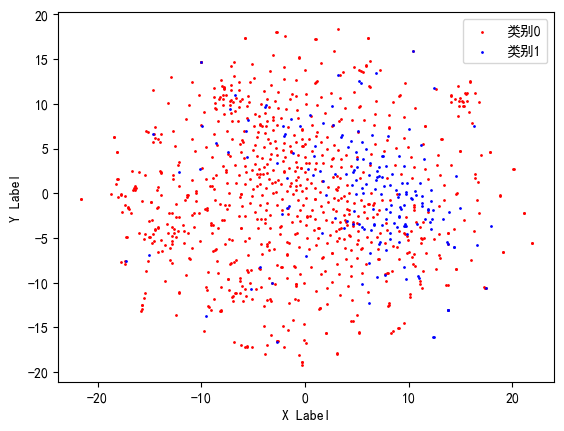

In [75]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# 应用t-SNE降维到二维
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(np.array(datas_layer29))

# 可视化
fig, ax = plt.subplots()

# 假设您有两个标签类别，用0和1表示
ax.scatter(data_tsne[labels_int == 0, 0], data_tsne[labels_int == 0, 1], c='r', s=1, label='类别0')
ax.scatter(data_tsne[labels_int == 1, 0], data_tsne[labels_int == 1, 1], c='b', s=1, label='类别1')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.legend()

plt.show()

In [66]:
type(labels_int)

list

In [64]:
data_tsne[labels_int == 0, 0]

array([], shape=(0, 1034, 3), dtype=float32)